# Data Scientist Challenge

#### This project focuses on analyzing student behavior and study patterns with specific objectives. It aims to explore demographic characteristics associated with test success, evaluate study effectiveness, uncover dataset trends, and provide insightful analyses on their implications.

#### Additionally, the project seeks to build a predictive model to forecast students' likelihood of passing the test. The resulting findings will be disseminated, accompanied by recommendations to improve support strategies for helping more students pass. The ultimate goal is to enhance the accuracy of predictive models by leveraging insights gleaned from this research.

## About this dataset

The data was collected from the Faculty of Engineering and Faculty of Educational Sciences students in 2019. The purpose is to predict students' end-of-term performances using ML techniques.

1-10 of the data are the personal questions, 11-16. questions include family questions, and the remaining questions include education habits.

|Column Name| Description|Values|Datatype|
|:------------|:------------|:--------------|:------------------------
|id| Student ID|-|Integer|
|age| Age of the student|1: 18-21, 2: 22-25, 3: above 26|Categorical|
|gender| Gender of the student|1: female, 2: male|Binary|
|hs_type| Graduated high-school type|1: private, 2: state, 3: other|Categorical|
|sch_type| Scholarship type|1: None, 2: 25%, 3: 50%, 4: 75%, 5: Full|Categorical|
|work| Additional work|1: Yes, 2: No|Binary|
|ex_act| Regular artistic or sports activity|1: Yes, 2: No|Binary|
|partner| Do you have a partner |1: Yes, 2: No|Binary|
|salary| Total salary if available|1: USD 135-200, 2: USD 201-270, 3: USD 271-340, 4: USD 341-410, 5: above 410|Categorical|
|transp| Transportation to the university|1: Bus, 2: Private car/taxi, 3: bicycle, 4: Other|Categorical|
|acc_type| Accomodation type in Cyprus|1: rental, 2: dormitory, 3: with family, 4: Other|Categorical|
|mo_edu| Mother's education|1: primary school, 2: secondary school, 3: high school, 4: university, 5: MSc., 6: Ph.D.|Categorical|
|fa_edu| Father's education|1: primary school, 2: secondary school, 3: high school, 4: university, 5: MSc., 6: Ph.D.|Categorical|
|n_sib| Number of sisters/brothers (if available)|1: 1, 2:, 2, 3: 3, 4: 4, 5: 5 or above|Integer|
|p_stus| Parental status|1: married, 2: divorced, 3: died - one of them or both|Categorical|
|mo_occ| Mother's occupation|1: retired, 2: housewife, 3: government officer, 4: private sector employee, 5: self-employment, 6: other|Categorical|
|fa_occ| Father's occupation|1: retired, 2: housewife, 3: government officer, 4: private sector employee, 5: self-employment, 6: other|Categorical|
|w_hours| Weekly study hours|1: None, 2: <5 hours, 3: 6-10 hours, 4: 11-20 hours, 5: more than 20 hours|Categorical|
|frec_nsci| Reading frequency|1: None, 2: Sometimes, 3: Often (non-scientific books/journals)|Categorical|
|frec_sci| Reading frequency|1: None, 2: Sometimes, 3: Often (scientific books/journals)|Categorical|
|att_sem| Attendance to the seminars/conferences related to the department|1: Yes, 2: No|Binary|
|impact| Impact of your projects/activities on your success|1: positive, 2: negative, 3: neutral|Categorical|
|att| Attendance to classes|1: always, 2: sometimes, 3: never|Categorical|
|prep_stus| Preparation to midterm exams 1|1: alone, 2: with friends, 3: not applicable|Categorical|
|prep_reg| Preparation to midterm exams 2|1: closest date to the exam, 2: regularly during the semester, 3: never|Categorical|
|notes| Taking notes in classes|1: never, 2: sometimes, 3: always no|Categorical|
|listng| Listening in classes|1: never, 2: sometimes, 3: always	no|Categorical|
|interest| Discussion improves my interest and success in the course|1: never, 2: sometimes, 3: always no|Categorical|
|flip| Flip-classroom|1: not useful, 2: useful, 3: not applicable|Categorical|
|cum_s| Cumulative grade point average in the last semester|1: <2.00, 2: 2.00-2.49, 3: 2.50-2.99, 4: 3.00-3.49, 5: above 3.49|Categorical|
|cum_g| Expected Cumulative grade point average in the graduation|1: <2.00, 2: 2.00-2.49, 3: 2.50-2.99, 4: 3.00-3.49, 5: above 3.49|Categorical|
|course_id| Course ID|-|Integer|
|grade| OUTPUT Grade|0: Fail, 1: DD, 2: DC, 3: CC, 4: CB, 5: BB, 6: BA, 7: AA|Categorical|


In [1]:
# Import of relevant packages
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = [6, 4]

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, classification_report, auc, roc_auc_score, roc_curve, f1_score, average_precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans


# Setting random seed 
RSEED = 42
warnings.filterwarnings("ignore")

##  EDA / Analysis

In [2]:
df = pd.read_csv('data/DATA (1).csv')

In [3]:
df.head()

,STUDENT ID,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,COURSE ID,GRADE
0,STUDENT1,2,2,3,3,1,2,2,1,1,...,1,1,3,2,1,2,1,1,1,1
1,STUDENT2,2,2,3,3,1,2,2,1,1,...,1,1,3,2,3,2,2,3,1,1
2,STUDENT3,2,2,2,3,2,2,2,2,4,...,1,1,2,2,1,1,2,2,1,1
3,STUDENT4,1,1,1,3,1,2,1,2,1,...,1,2,3,2,2,1,3,2,1,1
4,STUDENT5,2,2,1,3,2,2,1,3,1,...,2,1,2,2,2,1,2,2,1,1


In [4]:
#df = df.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'})
# Renaming columns
col_names = ['id', 'age', 'gender', 'hs_type', 'sch_type', 
             'work', 'ex_act', 'partner', 'salary', 'transp',
             'acc_type', 'mo_edu', 'fa_edu', 'n_sib', 'p_stus',
             'mo_occ', 'fa_occ', 'w_hours', 'frec_nsci', 'frec_sci',
             'att_sem', 'impact', 'att', 'prep_stus', 'prep_reg','notes', 'listng',
              'interest', 'flip', 'cum_s', 'cum_g', 'course_id', 'grade']
df.columns = col_names

df['id'] = df['id'].apply(lambda x: x.strip('STUDENT')).astype(int)


In [5]:
df.head(2)

,id,age,gender,hs_type,sch_type,work,ex_act,partner,salary,transp,...,prep_stus,prep_reg,notes,listng,interest,flip,cum_s,cum_g,course_id,grade
0,1,2,2,3,3,1,2,2,1,1,...,1,1,3,2,1,2,1,1,1,1
1,2,2,2,3,3,1,2,2,1,1,...,1,1,3,2,3,2,2,3,1,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 33 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   id         145 non-null    int32
 1   age        145 non-null    int64
 2   gender     145 non-null    int64
 3   hs_type    145 non-null    int64
 4   sch_type   145 non-null    int64
 5   work       145 non-null    int64
 6   ex_act     145 non-null    int64
 7   partner    145 non-null    int64
 8   salary     145 non-null    int64
 9   transp     145 non-null    int64
 10  acc_type   145 non-null    int64
 11  mo_edu     145 non-null    int64
 12  fa_edu     145 non-null    int64
 13  n_sib      145 non-null    int64
 14  p_stus     145 non-null    int64
 15  mo_occ     145 non-null    int64
 16  fa_occ     145 non-null    int64
 17  w_hours    145 non-null    int64
 18  frec_nsci  145 non-null    int64
 19  frec_sci   145 non-null    int64
 20  att_sem    145 non-null    int64
 21  impact     145 n

Checking unique values

In [7]:
print('Unique values per column:')
print('-' * 15)
df.nunique()
#df.value_counts().count()

Unique values per column:
---------------


id           145
age            3
gender         2
hs_type        3
sch_type       5
work           2
ex_act         2
partner        2
salary         5
transp         4
acc_type       4
mo_edu         6
fa_edu         6
n_sib          5
p_stus         3
mo_occ         5
fa_occ         5
w_hours        5
frec_nsci      3
frec_sci       3
att_sem        2
impact         3
att            2
prep_stus      3
prep_reg       3
notes          3
listng         3
interest       3
flip           3
cum_s          5
cum_g          4
course_id      9
grade          8
dtype: int64

### Impact of Demographic Factors on Performance

- Does age correlate with academic performance?
- Is there a significant difference in performance between male and female students?
- Do students from different high school backgrounds (private, state, other) perform differently?
- How does having a scholarship (and its percentage) affect academic performance?
- Does having additional work affect student performance?

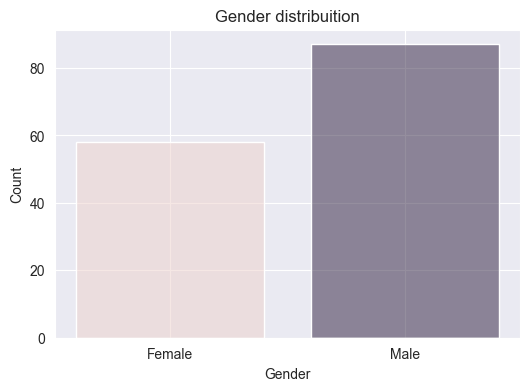

In [51]:
# Gender distribuition

fig = sns.histplot(data=df, x="gender", hue='gender', discrete=True, shrink=.8, multiple="layer", legend=False)#, y= 'grade', hue='gender', ci=None)#, estimator='std')

plt.title('Gender distribuition')
plt.xticks(np.arange(1, 3, step=1), ['Female', 'Male'])
plt.xlabel('Gender')

plt.show()

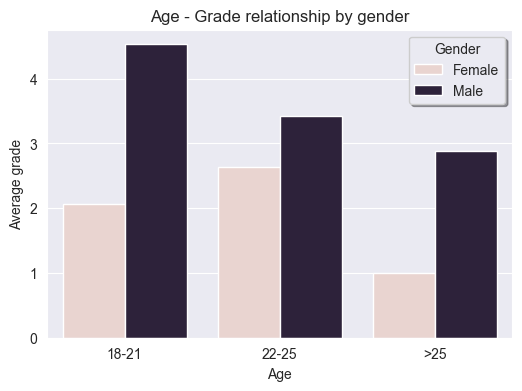

In [54]:
# Age - grades gender

fig = sns.barplot(data=df, x="age", y= 'grade', hue='gender', ci=None)#, estimator='std')

plt.title('Age - Grade relationship by gender')
plt.xticks(np.arange(0, 3, step=1), ['18-21', '22-25', '>25'])
plt.xlabel('Age')
plt.ylabel('Average grade')
plt.legend(title='Gender', labels = ['Female', 'Male'], shadow=True)
plt.show()

In [55]:
df.columns

Index(['id', 'age', 'gender', 'hs_type', 'sch_type', 'work', 'ex_act',
       'partner', 'salary', 'transp', 'acc_type', 'mo_edu', 'fa_edu', 'n_sib',
       'p_stus', 'mo_occ', 'fa_occ', 'w_hours', 'frec_nsci', 'frec_sci',
       'att_sem', 'impact', 'att', 'prep_stus', 'prep_reg', 'notes', 'listng',
       'interest', 'flip', 'cum_s', 'cum_g', 'course_id', 'grade'],
      dtype='object')

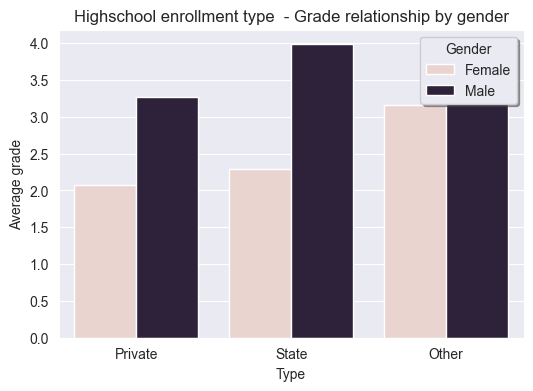

In [58]:
# Highschool - grades 

fig = sns.barplot(data=df, x="hs_type", y= 'grade', hue='gender', ci=None)

plt.title('Highschool enrollment type  - Grade relationship by gender')
plt.xticks(np.arange(0, 3, step=1), ['Private', 'State', 'Other'])
plt.xlabel('Type')
plt.ylabel('Average grade')
plt.legend(title='Gender', labels = ['Female', 'Male'], shadow=True)
plt.show()

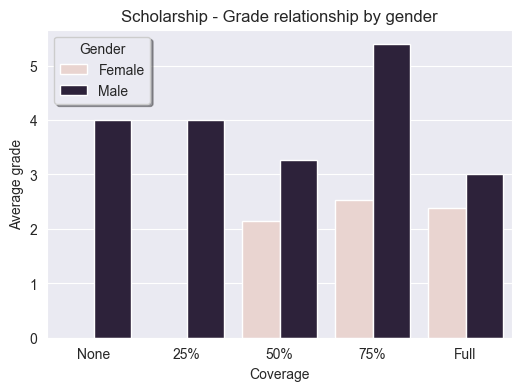

In [61]:
# Scholarship - grades 

fig = sns.barplot(data=df, x="sch_type", y= 'grade', hue='gender', ci=None)

plt.title('Scholarship - Grade relationship by gender')
plt.xticks(np.arange(0, 5, step=1), ['None', '25%', '50%', '75%', 'Full'])
plt.xlabel('Coverage')
plt.ylabel('Average grade')
plt.legend(title='Gender', labels = ['Female', 'Male'], shadow=True)
plt.show()

### Relationships with External Factors

- Does engagement in regular artistic or sports activities relate to academic performance?
- Is there a correlation between having a partner and academic performance?
- Do different levels of salary (if available) affect student performance?  

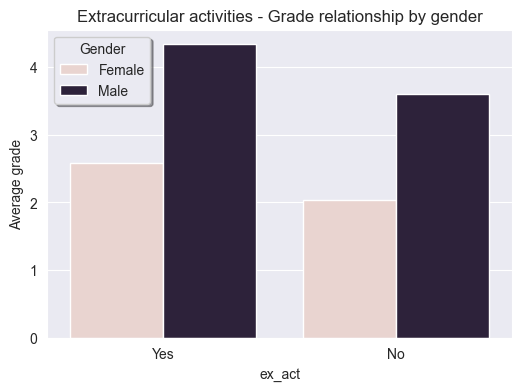

In [62]:
# Extracurricular - grades 

fig = sns.barplot(data=df, x="ex_act", y= 'grade', hue='gender', ci=None)

plt.title('Extracurricular activities - Grade relationship by gender')
plt.xticks(np.arange(0, 2, step=1), ['Yes', 'No'])
#plt.xlabel('Coverage')
plt.ylabel('Average grade')
plt.legend(title='Gender', labels = ['Female', 'Male'], shadow=True)
plt.show()

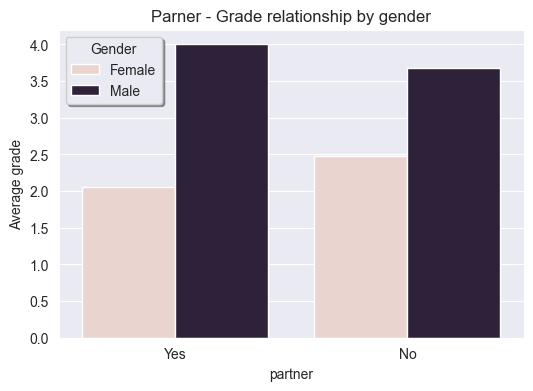

In [63]:
# Partner - grades 

fig = sns.barplot(data=df, x="partner", y= 'grade', hue='gender', ci=None)

plt.title('Parner - Grade relationship by gender')
plt.xticks(np.arange(0, 2, step=1), ['Yes', 'No'])
#plt.xlabel('Coverage')
plt.ylabel('Average grade')
plt.legend(title='Gender', labels = ['Female', 'Male'], shadow=True)
plt.show()

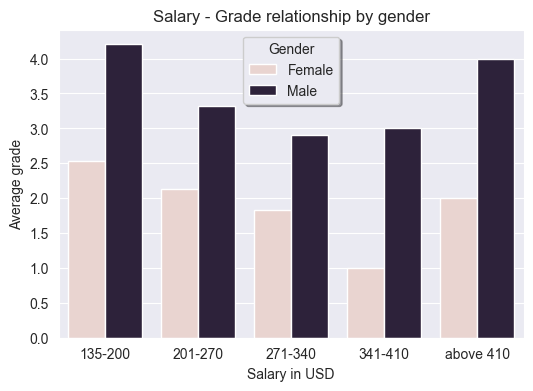

In [64]:
# Salary - grades 

fig = sns.barplot(data=df, x="salary", y= 'grade', hue='gender', ci=None)

plt.title('Salary - Grade relationship by gender')
plt.xticks(np.arange(0, 5, step=1), ['135-200', '201-270', '271-340', '341-410', 'above 410'])
plt.xlabel('Salary in USD')
plt.ylabel('Average grade')
plt.legend(title='Gender', labels = ['Female', 'Male'], shadow=True)
plt.show()

### Impact of Lifestyle and Study Habits

- How does the mode of transportation to the university affect academic performance?
- Does accommodation type in Cyprus influence academic performance?
- Do study hours per week correlate with academic performance?  

### Family Background and Educational Influence

- Does the level of education of the mother or father affect student performance?
- Is there a relationship between the number of siblings and academic performance?
- How does parental status (married, divorced, deceased) relate to academic performance?  

### Occupational Influence

- Does the occupation of the mother or father influence student performance?

### Reading Habits and Academic Performance

- How do reading habits (frequency of reading non-scientific and scientific materials) correlate with academic performance?  

7. Interactions and Multivariate Analysis:

- Are there interactions between different variables that significantly impact academic performance?
- How do combinations of factors (e.g., demographic, lifestyle, family background) affect academic performance?

### Train / Test split

In [10]:
X = df.drop(['id', 'grade'], axis=1)
y = df.grade

In [11]:
print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')

Shape of X: (145, 31)
Shape of y: (145,)


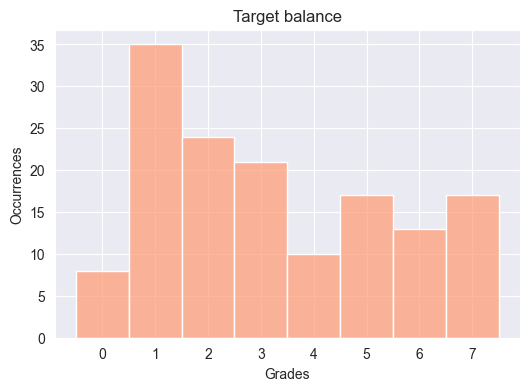

In [12]:
fig = plt.figure(figsize=(6, 4))

#ax = plt.hist(y, bins=8, color='lightsalmon')
sns.histplot(y, bins=8, color='lightsalmon', discrete=True)

plt.title('Target balance')
plt.xlabel('Grades')
plt.ylabel('Occurrences')
plt.xticks(np.arange(0, 8, step=1))

plt.show()

In [13]:
y.value_counts()

grade
1    35
2    24
3    21
5    17
7    17
6    13
4    10
0     8
Name: count, dtype: int64

In [14]:
X.columns

Index(['age', 'gender', 'hs_type', 'sch_type', 'work', 'ex_act', 'partner',
       'salary', 'transp', 'acc_type', 'mo_edu', 'fa_edu', 'n_sib', 'p_stus',
       'mo_occ', 'fa_occ', 'w_hours', 'frec_nsci', 'frec_sci', 'att_sem',
       'impact', 'att', 'prep_stus', 'prep_reg', 'notes', 'listng', 'interest',
       'flip', 'cum_s', 'cum_g', 'course_id'],
      dtype='object')

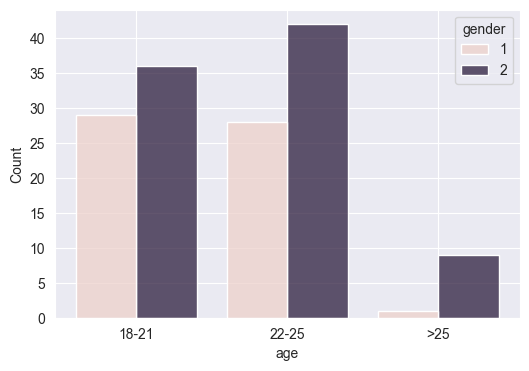

In [15]:
plt.figure(figsize=(6, 4))

fig = sns.histplot(data=X, x="age", hue='gender', discrete=True, shrink=.8, multiple="dodge")
plt.xticks(np.arange(1, 4, step=1), ['18-21', '22-25', '>25'])

plt.show()

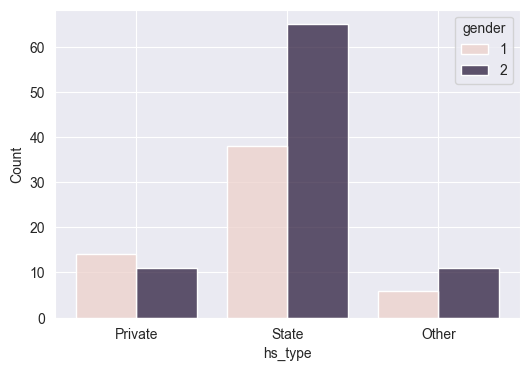

In [16]:
plt.figure(figsize=(6, 4))

fig = sns.histplot(data=X, x="hs_type", hue='gender', discrete=True, shrink=.8, multiple="dodge")
plt.xticks(np.arange(1, 4, step=1), ['Private', 'State', 'Other'])

plt.show()

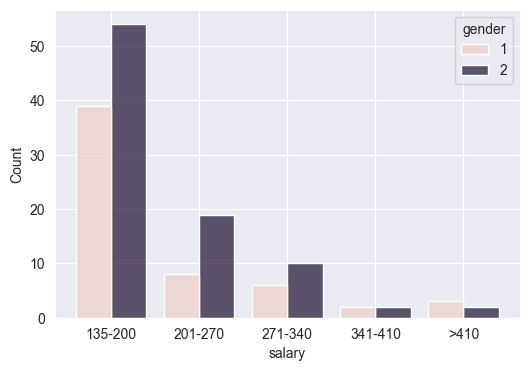

In [17]:
plt.figure(figsize=(6, 4))

fig = sns.histplot(data=X, x="salary", hue='gender', discrete=True, shrink=.8, multiple="dodge")
plt.xticks(np.arange(1, 6, step=1), ['135-200', '201-270', '271-340', '341-410',
                                     '>410'])

plt.show()

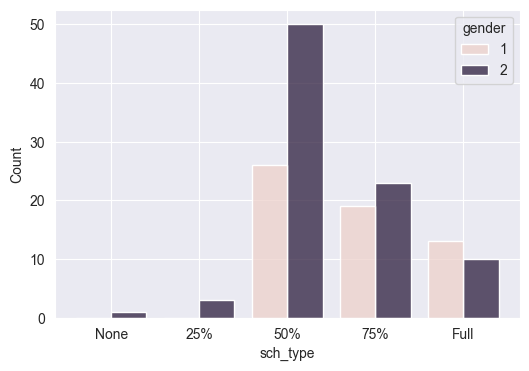

In [18]:
plt.figure(figsize=(6, 4))

fig = sns.histplot(data=X, x="sch_type", hue='gender', discrete=True, shrink=.8, multiple="dodge")
plt.xticks(np.arange(1, 6, step=1), ['None', '25%', '50%', '75%', 'Full'])

plt.show()

In [19]:
X.columns

Index(['age', 'gender', 'hs_type', 'sch_type', 'work', 'ex_act', 'partner',
       'salary', 'transp', 'acc_type', 'mo_edu', 'fa_edu', 'n_sib', 'p_stus',
       'mo_occ', 'fa_occ', 'w_hours', 'frec_nsci', 'frec_sci', 'att_sem',
       'impact', 'att', 'prep_stus', 'prep_reg', 'notes', 'listng', 'interest',
       'flip', 'cum_s', 'cum_g', 'course_id'],
      dtype='object')

After this first inspection we can see: 
- most of the student on this data are from Japan, they represent the 80 %. Therefore on this regard, the data is umbalanced.
- mojo_class has a huge impact on wether a student will pass the test or not
- test_prep doesn't has tha much impact, since many of the students whon passed din't take it. Also many of the ones whon didn't passed, didn't took it.
- the mean of hours studied is around 4. But the distributionsn between passed and not passed is very balanced. Below the mean the amount of not passed is quite higher, but up the mean is very balanced.
- the gender distribution is very unbalanced (hole dataset)

fix target balance

In [20]:
print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')

Shape of X: (145, 31)
Shape of y: (145,)


In [21]:
y.value_counts()

grade
1    35
2    24
3    21
5    17
7    17
6    13
4    10
0     8
Name: count, dtype: int64

In [22]:
x_copy = X.copy()
y_copy = y.copy()

In [23]:
'''from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.datasets import make_classification
x_copy, y_copy = make_classification(n_samples=5000, n_features=32,
                           n_classes=8, n_informative=4,
                           #n_clusters_per_class=1,
                           #weights=[0.01, 0.05, 0.94],
                           random_state=RSEED)
sm = SMOTE(random_state=RSEED)
X_resampled, y_resampled = sm.fit_resample(x_copy, y_copy)

from collections import Counter
print(sorted(Counter(y_resampled).items()))'''

'from imblearn.over_sampling import SMOTE, ADASYN\nfrom sklearn.datasets import make_classification\nx_copy, y_copy = make_classification(n_samples=5000, n_features=32,\n                           n_classes=8, n_informative=4,\n                           #n_clusters_per_class=1,\n                           #weights=[0.01, 0.05, 0.94],\n                           random_state=RSEED)\nsm = SMOTE(random_state=RSEED)\nX_resampled, y_resampled = sm.fit_resample(x_copy, y_copy)\n\nfrom collections import Counter\nprint(sorted(Counter(y_resampled).items()))'

In [24]:
#print(f'Shape of X: {X_resampled.shape}')
#print(f'Shape of y: {y_resampled.shape}')

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RSEED)

In [26]:
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.datasets import make_classification
X_train, y_train = make_classification(n_samples=5000, n_features=31,
                           n_classes=8, n_informative=4,
                           #n_clusters_per_class=1,
                           #weights=[0.01, 0.05, 0.94],
                           random_state=RSEED)
sm = SMOTE(random_state=RSEED)
X_train, y_train = sm.fit_resample(X_train, y_train)

from collections import Counter
print(sorted(Counter(y_train).items()))

[(0, 631), (1, 631), (2, 631), (3, 631), (4, 631), (5, 631), (6, 631), (7, 631)]


In [27]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (5048, 31)
X_test shape: (29, 31)
y_train shape: (5048,)
y_test shape: (29,)


### Logistic regression as baseline model

In [28]:
# Create a logistic regression model

#baseline_lr = LogisticRegression(max_iter=800, multi_class='multinomial', solver='lbfgs', random_state=RSEED) 
baseline_lr = LogisticRegression(max_iter=800, multi_class='ovr', random_state=RSEED) 

In [29]:
# Train the model
baseline_lr.fit(X_train, y_train)

LogisticRegression(max_iter=800, multi_class='ovr', random_state=42)

In [30]:
# Make predictions on the test set
y_pred = baseline_lr.predict(X_test)

In [31]:
# Predicting on train data 
y_train_pred = baseline_lr.predict(X_train)
y_train_prob = baseline_lr.predict_proba(X_train)[:, 1]

# Testing predictions (to determine performance)
y_pred = baseline_lr.predict(X_test)
y_prob = baseline_lr.predict_proba(X_test)[:, 1]

### Results on Training data

Accuracy : 0.57
Recall : 0.57
Precision: 0.57
------------------------------------------------------------
Classification Report:               precision    recall  f1-score   support

           0       0.55      0.53      0.54       631
           1       0.63      0.61      0.62       631
           2       0.56      0.54      0.55       631
           3       0.66      0.57      0.61       631
           4       0.53      0.57      0.55       631
           5       0.52      0.55      0.53       631
           6       0.51      0.51      0.51       631
           7       0.60      0.67      0.64       631

    accuracy                           0.57      5048
   macro avg       0.57      0.57      0.57      5048
weighted avg       0.57      0.57      0.57      5048



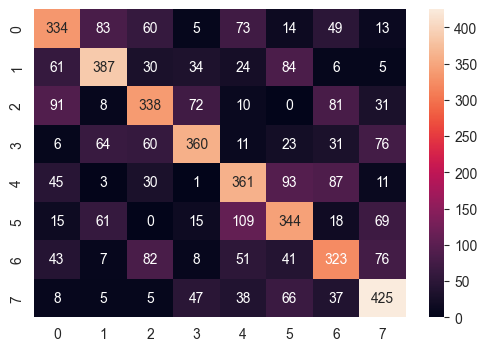

In [32]:
print('Accuracy : {:.2f}'.format(accuracy_score(y_train, y_train_pred, normalize=True)))
print('Recall : {:.2f}'.format(recall_score(y_train, y_train_pred, average='macro')))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_pred, average='macro')))
#print("ROC: {:.2f}".format(roc_auc_score(y_train, train_rf_probs, multi_class='ovr')))
print('------'*10)
print(f'Classification Report: {classification_report(y_train, y_train_pred)}') 

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, fmt = 'd')

plt.show()

### Results on Test data

In [33]:
y_pred.shape

(29,)

Accuracy : 0.03
Recall : 0.03
Precision: 0.03
------------------------------------------------------------
Classification Report:               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         2
           5       0.10      0.33      0.15         3
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         3

    accuracy                           0.03        29
   macro avg       0.01      0.04      0.02        29
weighted avg       0.01      0.03      0.02        29



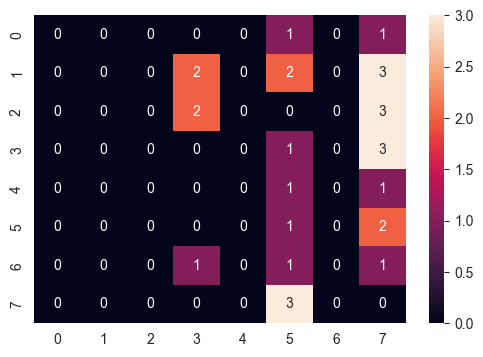

<Figure size 800x600 with 0 Axes>

In [34]:
#
# Printing results
print('Accuracy : {:.2f}'.format(accuracy_score(y_test, y_pred, normalize=True)))
print('Recall : {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print("Precision: {:.2f}".format(precision_score(y_test, y_pred, average='micro')))

#print("ROC: {:.2f}".format(roc_auc_score(y_test, y_prob)))
print('------'*10)
print(f'Classification Report: {classification_report(y_test, y_pred)}') 

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt = 'd')

plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16


As espected, the results are better on training set that on test set, but the differences aren't that huge

### Training a random forest model

In [35]:
pipe_rf = Pipeline([
    ('rf', RandomForestClassifier())
])


In [36]:
param_rf = {
                'rf__n_estimators': [100],
                'rf__max_features': ['sqrt', 'log2'],
                'rf__max_depth': [4, 6, 8],
                'rf__class_weight': ['balanced', 'balanced_subsample'],
                'rf__random_state': [RSEED],
                'rf__n_estimators': [100],
                'rf__criterion': ['gini'],
                'rf__bootstrap': [False]
               }


grid_rf = GridSearchCV(pipe_rf, param_grid=param_rf, cv=5, scoring= 'accuracy', 
                           verbose=5, n_jobs=-1)

In [37]:
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=Pipeline(steps=[('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__bootstrap': [False],
                         'rf__class_weight': ['balanced', 'balanced_subsample'],
                         'rf__criterion': ['gini'], 'rf__max_depth': [4, 6, 8],
                         'rf__max_features': ['sqrt', 'log2'],
                         'rf__n_estimators': [100], 'rf__random_state': [42]},
             scoring='accuracy', verbose=5)

In [38]:
print('Best score:\n{:.2f}'.format(grid_rf.best_score_))
print("Best parameters:\n{}".format(grid_rf.best_params_))

Best score:
0.62
Best parameters:
{'rf__bootstrap': False, 'rf__class_weight': 'balanced', 'rf__criterion': 'gini', 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__n_estimators': 100, 'rf__random_state': 42}


In [39]:
best_model_dt = grid_rf.best_estimator_
best_model_dt

Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False,
                                        class_weight='balanced', max_depth=8,
                                        random_state=42))])

In [40]:
# Training predictions (to demonstrate overfitting)
train_rf_predictions = best_model_dt.predict(X_train)
train_rf_probs = best_model_dt.predict_proba(X_train)[:, 1]

# Testing predictions (to determine performance)
rf_predictions = best_model_dt.predict(X_test)
rf_probs = best_model_dt.predict_proba(X_test)[:, 1]

In [41]:

rf_model = RandomForestClassifier(n_estimators=100,
                                  criterion='gini',
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               max_depth=8,
                               class_weight='balanced_subsample',
                               n_jobs=-1, 
                               verbose = 1,
                               bootstrap=False)
rf_model.fit(X_train, y_train)


n_nodes = []
max_depths = []

for ind_tree in rf_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

# Training predictions (to demonstrate overfitting)
train_rf_predictions = rf_model.predict(X_train)
train_rf_probs = rf_model.predict_proba(X_train)[:, 1]

# Testing predictions (to determine performance)
rf_predictions = rf_model.predict(X_test)
rf_probs = rf_model.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s


Average number of nodes 322
Average maximum depth 8


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


### Results on Training set

Accuracy : 0.75
Recall : 0.75
Precision: 0.75
------------------------------------------------------------
Classification Report:               precision    recall  f1-score   support

           0       0.73      0.65      0.68       631
           1       0.78      0.75      0.77       631
           2       0.74      0.73      0.73       631
           3       0.83      0.69      0.75       631
           4       0.69      0.87      0.77       631
           5       0.75      0.72      0.73       631
           6       0.77      0.73      0.75       631
           7       0.72      0.83      0.77       631

    accuracy                           0.75      5048
   macro avg       0.75      0.75      0.74      5048
weighted avg       0.75      0.75      0.74      5048



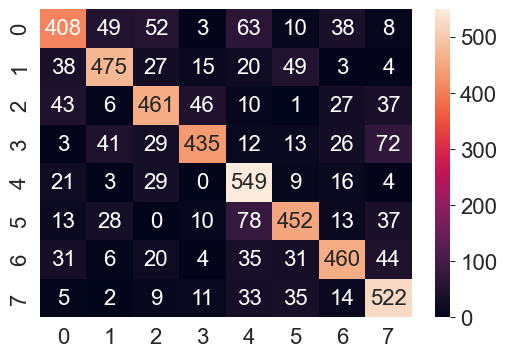

<Figure size 800x600 with 0 Axes>

In [42]:


# Printing results

print('Accuracy : {:.2f}'.format(accuracy_score(y_train, train_rf_predictions, normalize=True)))
print('Recall : {:.2f}'.format(recall_score(y_train, train_rf_predictions, average='macro')))
print("Precision: {:.2f}".format(precision_score(y_train, train_rf_predictions, average='macro')))
#print("ROC: {:.2f}".format(roc_auc_score(y_train, train_rf_probs, multi_class='ovr')))
print('------'*10)
print(f'Classification Report: {classification_report(y_train, train_rf_predictions)}') 

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_train, train_rf_predictions), annot=True, fmt = 'd')

plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16




### Results ion test set

Accuracy : 0.10
Recall : 0.12
Precision: 0.01
------------------------------------------------------------
Classification Report:               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         3
           7       0.10      1.00      0.19         3

    accuracy                           0.10        29
   macro avg       0.01      0.12      0.02        29
weighted avg       0.01      0.10      0.02        29



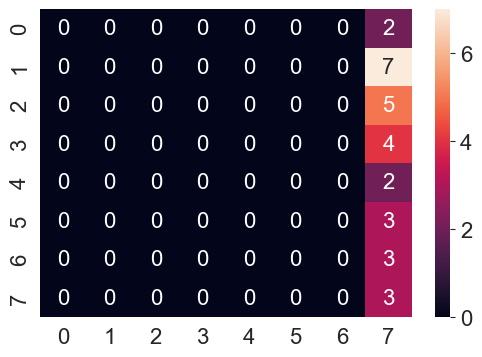

<Figure size 800x600 with 0 Axes>

In [43]:
# Printing results

print('Accuracy : {:.2f}'.format(accuracy_score(y_test, rf_predictions, normalize=True)))
print('Recall : {:.2f}'.format(recall_score(y_test, rf_predictions, average='macro')))
print("Precision: {:.2f}".format(precision_score(y_test, rf_predictions, average='macro')))
#print("ROC: {:.2f}".format(roc_auc_score(y_test, train_rf_probs, multi_class='ovr')))
print('------'*10)
print(f'Classification Report: {classification_report(y_test, rf_predictions)}') 

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_test, rf_predictions), annot=True, fmt = 'd')

plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16

It seems that the model was overfitting the data, since the diference in the results are notizable

### Training a XGBoostClassifier with pipeline

In [44]:

pipe_xgb = Pipeline([
    ('xgb', XGBClassifier())
])


setting parameters

In [45]:
param_xgb = {'xgb__base_score':[0.7],
                'xgb__booster': ['gbtree'],
                'xgb__learning_rate': [0.1, 0.01, 0.001],
                'xgb__max_depth': [2, 4, 6, 8],
                'xgb__random_state': [RSEED],
                'xgb__n_estimators': [100],
                'xgb__colsample_bytree': [0.5]
               }

grid_xgb = GridSearchCV(pipe_xgb, param_grid=param_xgb, cv=5, scoring= 'accuracy', 
                           verbose=5, n_jobs=-1)

In [46]:
grid_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=None,
                                                      interaction_constraints=N...
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'xgb__base_score': [0.7], 'xgb__booster': ['gbtree'],
                         'xgb__colsample_bytree': [0.5],
                         'xgb__learning_rate': [0.1, 0.01, 0.001],
                         'xgb__max_depth': [2, 4, 6, 8],
                         'xgb__n_estimators': [100],
                         'xgb__random_state': [42]},
             scoring='accuracy', verbose=5)

In [47]:
print('Best score:\n{:.2f}'.format(grid_xgb.best_score_))
print("Best parameters:\n{}".format(grid_xgb.best_params_))

Best score:
0.66
Best parameters:
{'xgb__base_score': 0.7, 'xgb__booster': 'gbtree', 'xgb__colsample_bytree': 0.5, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 8, 'xgb__n_estimators': 100, 'xgb__random_state': 42}


In [48]:
best_model_dt = grid_xgb.best_estimator_
best_model_dt

Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.7, booster='gbtree', callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.5, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=8, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [49]:
# Training predictions (to demonstrate overfitting)
train_xgb_predictions = best_model_dt.predict(X_train)
train_xgb_probs = best_model_dt.predict_proba(X_train)[:, 1]

# Testing predictions (to determine performance)
xgb_predictions = best_model_dt.predict(X_test)
xgb_probs = best_model_dt.predict_proba(X_test)[:, 1]

### Predictions on training

Accuracy : 0.94
Recall : 0.94
Precision: 0.94
------------------------------------------------------------
Classification Report:               precision    recall  f1-score   support

           0       0.97      0.92      0.94       631
           1       0.92      0.96      0.94       631
           2       0.94      0.92      0.93       631
           3       0.94      0.90      0.92       631
           4       0.94      0.97      0.96       631
           5       0.97      0.94      0.95       631
           6       0.95      0.96      0.95       631
           7       0.92      0.98      0.95       631

    accuracy                           0.94      5048
   macro avg       0.94      0.94      0.94      5048
weighted avg       0.94      0.94      0.94      5048



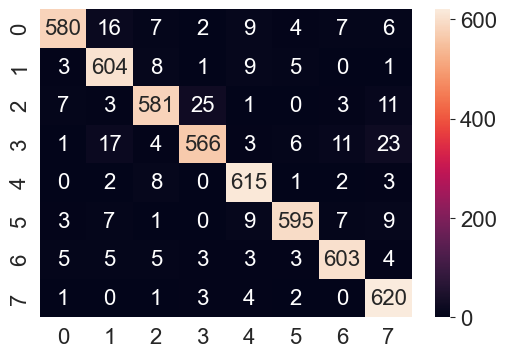

In [50]:
# Printing results

print('Accuracy : {:.2f}'.format(accuracy_score(y_train, train_xgb_predictions, normalize=True)))
print('Recall : {:.2f}'.format(recall_score(y_train, train_xgb_predictions, average='macro')))
print("Precision: {:.2f}".format(precision_score(y_train, train_xgb_predictions, average='macro')))
#print("ROC: {:.2f}".format(roc_auc_score(y_train, train_rf_probs, multi_class='ovr')))
print('------'*10)
print(f'Classification Report: {classification_report(y_train, train_xgb_predictions)}') 

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_train, train_xgb_predictions), annot=True, fmt = 'd')

plt.show()

### Predictions on test

Accuracy : 0.07
Recall : 0.08
Precision: 0.01
------------------------------------------------------------
Classification Report:               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         3
           7       0.07      0.67      0.13         3

    accuracy                           0.07        29
   macro avg       0.01      0.08      0.02        29
weighted avg       0.01      0.07      0.01        29



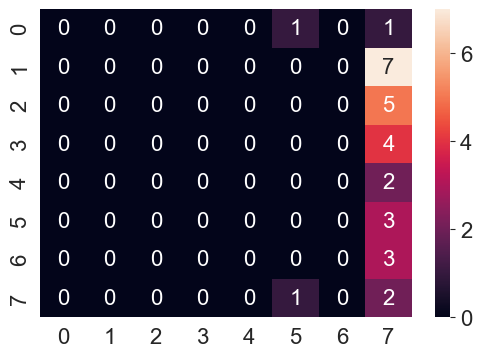

In [51]:
# Printing results

print('Accuracy : {:.2f}'.format(accuracy_score(y_test, xgb_predictions, normalize=True)))
print('Recall : {:.2f}'.format(recall_score(y_test, xgb_predictions, average='macro')))
print("Precision: {:.2f}".format(precision_score(y_test, xgb_predictions, average='macro')))
#print("ROC: {:.2f}".format(roc_auc_score(y_test, train_rf_probs, multi_class='ovr')))
print('------'*10)
print(f'Classification Report: {classification_report(y_test, xgb_predictions)}') 

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_test, xgb_predictions), annot=True, fmt = 'd')

plt.show()

### Training a knn model

In [52]:
pipe_knn = Pipeline([
    #('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier())
])

In [53]:
knn__cross_pred = cross_val_predict(pipe_knn, X_train, y_train, cv=5)

In [54]:
print('Cross validation scores:')
print('-------------------------')
print("Accuracy: {:.2f}".format(accuracy_score(y_train, knn__cross_pred)))
print("Recall: {:.2f}".format(recall_score(y_train, knn__cross_pred, average='micro')))
print("Precision: {:.2f}".format(precision_score(y_train, knn__cross_pred, average='micro')))

Cross validation scores:
-------------------------
Accuracy: 0.48
Recall: 0.48
Precision: 0.48


Looking for best k value

In [55]:
def knn_best_model(X_train, X_test, y_train, y_test):
    train_score = []
    test_score = []

    for i in range(1, 21):
        kn = KNeighborsClassifier(n_neighbors=i)
        kn.fit(X_train, np.ravel(y_train))
        ts_score = kn.score(X_test, y_test)#.round(2)
        trn_score = kn.score(X_train, y_train)#.round(2)
        test_score.append((ts_score))
        train_score.append(trn_score)
        i+=i

    best_score = max(test_score)
    best_k = [i for i, k in enumerate(test_score) if k == best_score]
    print(f'Best score for test data: {best_score}')
    print(f'Best k-value for test data: {best_k}')

    plt.figure(figsize=(10, 8))
    sns.lineplot(x = np.arange(len(test_score)), y = test_score, label = 'Test Score', marker= 'o')
    sns.lineplot(x = np.arange(len(train_score)), y = train_score, label = 'Train Score', marker= '*')
    plt.title('Score Comparison between Train and Test data')
    plt.xlabel('K-value')
    plt.ylabel('Score')
    plt.show()

Best score for test data: 0.20689655172413793
Best k-value for test data: [6, 8, 13]


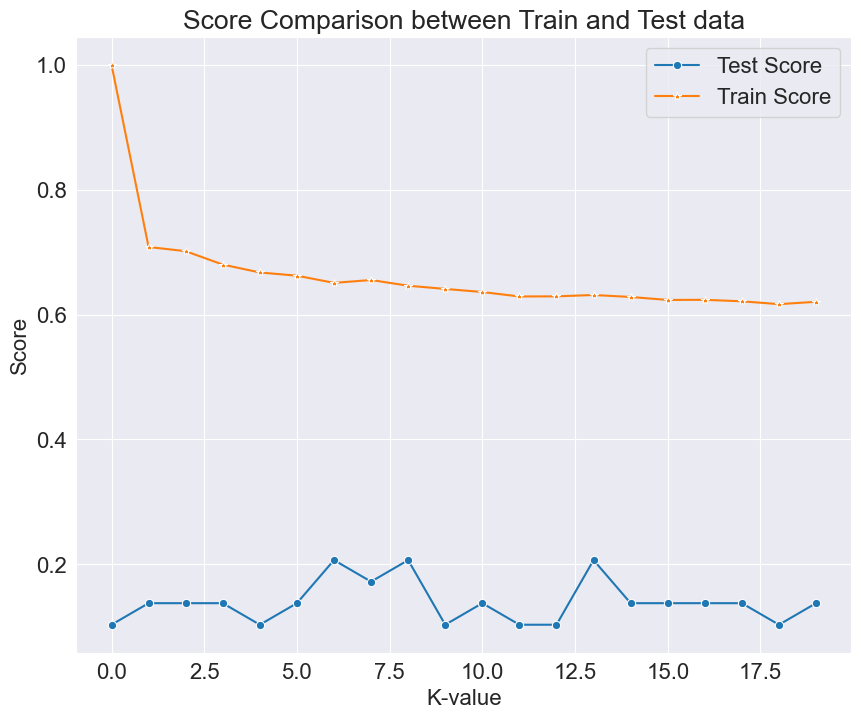

In [56]:
knn_best_model(X_train, X_test, y_train, y_test)

Optimizing the data

In [57]:
n_neighbours = np.arange(1, 21, 1)
param_knn = {'knn__n_neighbors':n_neighbours,
                'knn__algorithm': ['brute', 'ball_tree', 'kd_tree'],
                'knn__metric': ['minkowski', 'euclidean'],
                'knn__weights': ['uniform', 'distance']
               }

grid_knn = GridSearchCV(pipe_knn, param_grid=param_knn, cv=5, refit='recall', scoring=['recall', 'precision', 'accuracy'], 
                           verbose=1, n_jobs=-1)

In [58]:
grid_knn.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


GridSearchCV(cv=5, estimator=Pipeline(steps=[('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__algorithm': ['brute', 'ball_tree', 'kd_tree'],
                         'knn__metric': ['minkowski', 'euclidean'],
                         'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]),
                         'knn__weights': ['uniform', 'distance']},
             refit='recall', scoring=['recall', 'precision', 'accuracy'],
             verbose=1)

In [59]:
print('Best score:\n{:.2f}'.format(grid_knn.best_score_))
print("Best parameters:\n{}".format(grid_knn.best_params_))

Best score:
nan
Best parameters:
{'knn__algorithm': 'brute', 'knn__metric': 'minkowski', 'knn__n_neighbors': 1, 'knn__weights': 'uniform'}


In [60]:
best_model_knn = grid_knn.best_estimator_
best_model_knn

Pipeline(steps=[('knn',
                 KNeighborsClassifier(algorithm='brute', n_neighbors=1))])

In [61]:
# Training predictions (to demonstrate overfitting)
train_knn_predictions = best_model_knn.predict(X_train)
train_knn_probs = best_model_knn.predict_proba(X_train)[:, 1]

# Testing predictions (to determine performance)
knn_predictions = best_model_knn.predict(X_test)


#### Results on train data

Accuracy : 1.00
Recall : 1.00
Precision: 1.00
------------------------------------------------------------
Classification Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00       631
           1       1.00      1.00      1.00       631
           2       1.00      1.00      1.00       631
           3       1.00      1.00      1.00       631
           4       1.00      1.00      1.00       631
           5       1.00      1.00      1.00       631
           6       1.00      1.00      1.00       631
           7       1.00      1.00      1.00       631

    accuracy                           1.00      5048
   macro avg       1.00      1.00      1.00      5048
weighted avg       1.00      1.00      1.00      5048



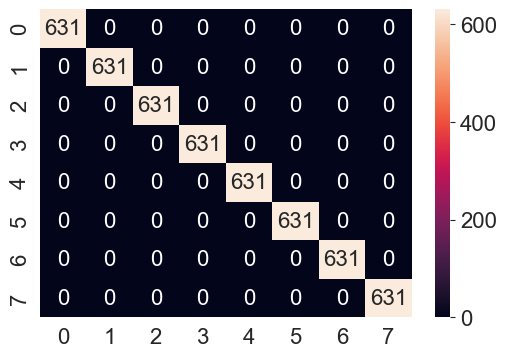

<Figure size 800x600 with 0 Axes>

In [62]:
# Printing results

print('Accuracy : {:.2f}'.format(accuracy_score(y_train, train_knn_predictions, normalize=True)))
print('Recall : {:.2f}'.format(recall_score(y_train, train_knn_predictions, average='macro')))
print("Precision: {:.2f}".format(precision_score(y_train, train_knn_predictions, average='macro')))
#print("ROC: {:.2f}".format(roc_auc_score(y_train, train_rf_probs, multi_class='ovr')))
print('------'*10)
print(f'Classification Report: {classification_report(y_train, train_knn_predictions)}') 

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_train, train_knn_predictions), annot=True, fmt = 'd')

plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16

plt.show()

#### Results on train data

Accuracy : 0.10
Recall : 0.12
Precision: 0.11
------------------------------------------------------------
Classification Report:               precision    recall  f1-score   support

           0       0.08      0.50      0.13         2
           1       0.00      0.00      0.00         7
           2       0.50      0.20      0.29         5
           3       0.33      0.25      0.29         4
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         3

    accuracy                           0.10        29
   macro avg       0.11      0.12      0.09        29
weighted avg       0.14      0.10      0.10        29



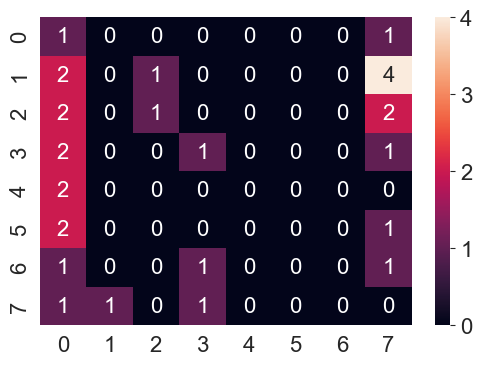

In [63]:
# Printing results

print('Accuracy : {:.2f}'.format(accuracy_score(y_test, knn_predictions, normalize=True)))
print('Recall : {:.2f}'.format(recall_score(y_test, knn_predictions, average='macro')))
print("Precision: {:.2f}".format(precision_score(y_test, knn_predictions, average='macro')))
#print("ROC: {:.2f}".format(roc_auc_score(y_test, train_rf_probs, multi_class='ovr')))
print('------'*10)
print(f'Classification Report: {classification_report(y_test, knn_predictions)}') 

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_test, knn_predictions), annot=True, fmt = 'd')

plt.show()

### Training a SVM model

In [73]:
from sklearn import svm

In [74]:
#Create a svm Classifier
svm_classifier= svm.SVC(kernel='poly', degree=8, gamma='auto',
                        decision_function_shape='ovr', class_weight='balanced' ) # Linear Kernel

#Train the model using the training sets
svm_classifier_model=svm_classifier.fit(X_train, y_train)

#Predict the response for test dataset
svm_predictions = svm_classifier.predict(X_test)

#Predict the response for train dataset
svm_train_predictions = svm_classifier.predict(X_train)

     

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1248427830.py, line 2)

#### Results on train data

Accuracy : 0.89
Recall : 0.89
Precision: 0.90
------------------------------------------------------------
Classification Report:               precision    recall  f1-score   support

           0       0.90      0.87      0.88       503
           1       0.84      0.95      0.89       503
           2       0.89      0.89      0.89       502
           3       0.95      0.79      0.87       502
           4       0.90      0.89      0.90       502
           5       0.94      0.92      0.93       503
           6       0.87      0.90      0.89       502
           7       0.88      0.93      0.90       502

    accuracy                           0.89      4019
   macro avg       0.90      0.89      0.89      4019
weighted avg       0.90      0.89      0.89      4019



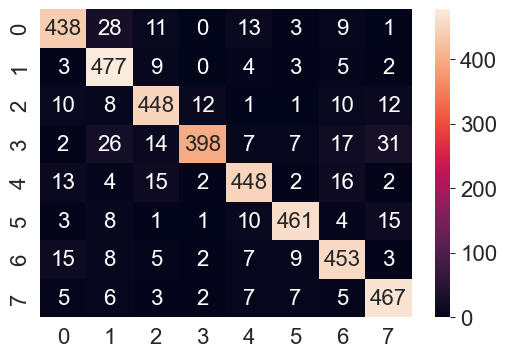

In [ ]:
# Printing results

print('Accuracy : {:.2f}'.format(accuracy_score(y_train, svm_train_predictions, normalize=True)))
print('Recall : {:.2f}'.format(recall_score(y_train, svm_train_predictions, average='macro')))
print("Precision: {:.2f}".format(precision_score(y_train, svm_train_predictions, average='macro')))
#print("ROC: {:.2f}".format(roc_auc_score(y_test, train_rf_probs, multi_class='ovr')))
print('------'*10)
print(f'Classification Report: {classification_report(y_train, svm_train_predictions)}') 

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_train, svm_train_predictions), annot=True, fmt = 'd')

plt.show()

#### Results on test data

Accuracy : 0.61
Recall : 0.61
Precision: 0.62
------------------------------------------------------------
Classification Report:               precision    recall  f1-score   support

           0       0.57      0.54      0.56       125
           1       0.66      0.70      0.68       125
           2       0.53      0.60      0.56       126
           3       0.77      0.56      0.65       126
           4       0.64      0.63      0.64       126
           5       0.56      0.60      0.58       125
           6       0.55      0.52      0.53       126
           7       0.68      0.76      0.72       126

    accuracy                           0.61      1005
   macro avg       0.62      0.61      0.61      1005
weighted avg       0.62      0.61      0.61      1005



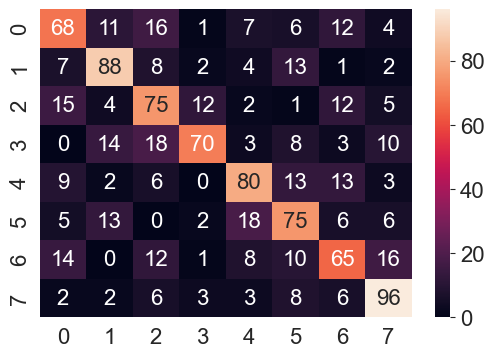

In [ ]:
# Printing results

print('Accuracy : {:.2f}'.format(accuracy_score(y_test, svm_predictions, normalize=True)))
print('Recall : {:.2f}'.format(recall_score(y_test, svm_predictions, average='macro')))
print("Precision: {:.2f}".format(precision_score(y_test, svm_predictions, average='macro')))
#print("ROC: {:.2f}".format(roc_auc_score(y_test, train_rf_probs, multi_class='ovr')))
print('------'*10)
print(f'Classification Report: {classification_report(y_test, svm_predictions)}') 

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_test, svm_predictions), annot=True, fmt = 'd')

plt.show()